### Le but ici va être de faire le candidate selection à partir du pre-processing

In [31]:
import pre_processing as pp
import os
import dicom
import pylab
import os
import math


import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import skimage, os
from skimage.morphology import ball, disk, dilation, binary_erosion, remove_small_objects, erosion, closing, reconstruction, binary_closing
from skimage.measure import label,regionprops, perimeter
from skimage.morphology import binary_dilation, binary_opening
from skimage.filters import roberts, sobel
from skimage import measure, feature
from skimage.segmentation import clear_border
from skimage import data
from scipy import ndimage as ndi
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from mpl_toolkits.mplot3d import Axes3D

In [32]:
INPUT_FOLDER = '/home/lucsoret/Projet/Supelec/CEI/Data/sample_validation_images'

patients = os.listdir(INPUT_FOLDER)
first_patient_path = os.path.join(INPUT_FOLDER,patients[0])
first_patient = pp.load_scan(first_patient_path)
total_images = os.listdir(first_patient_path)

In [33]:
patients

['00cba091fa4ad62cc3200a657aeb957e']

__Pas besoin de tout pre_process, ici on n'appliquer pas la normalisation et le zeropadding__

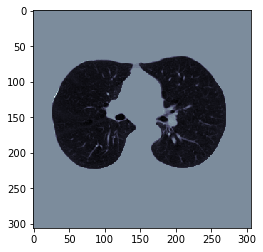

In [34]:
image = pp.PixelData_to_HU(first_patient)
image,space = pp.resample(image,first_patient)
image = np.stack([pp.get_segmented_lungs(s) for s in image])

plt.imshow(image[200], cmap=plt.cm.bone) 

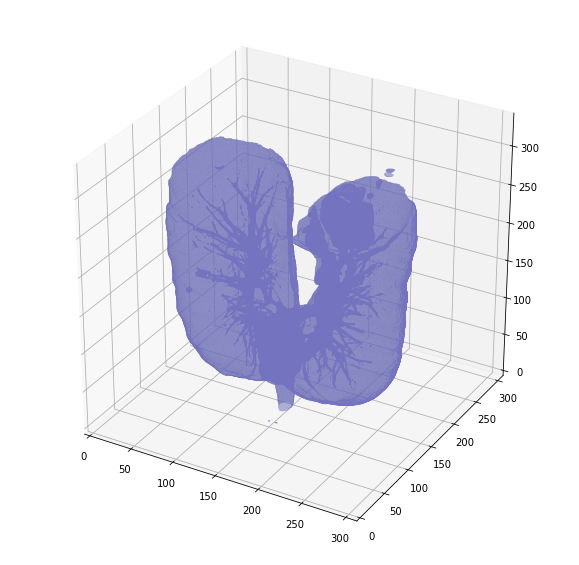

In [35]:
plot_3d(image,-300)

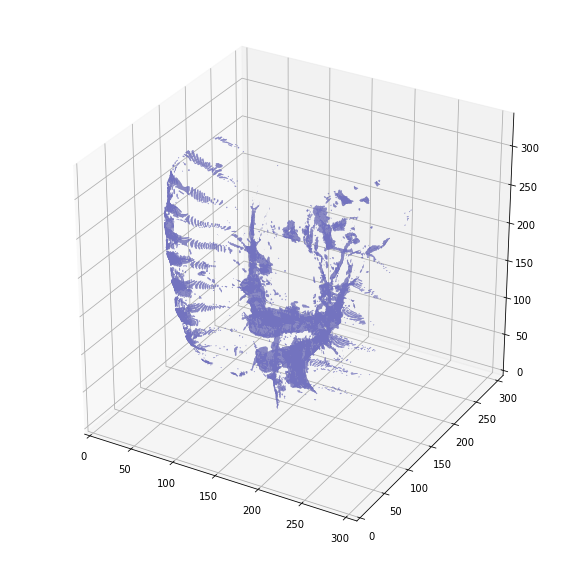

In [36]:
plot_3d(image,0)

In [41]:
def plot_ct_scan(scan):
    f, plots = plt.subplots(int(scan.shape[0] / 20) + 1, 4, figsize=(25, 25))
    for i in range(0, scan.shape[0], 5):
        plots[int(i / 20), int((i % 20) / 5)].axis('off')
        plots[int(i / 20), int((i % 20) / 5)].imshow(scan[i], cmap=plt.cm.bone) 

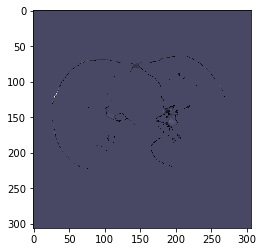

In [38]:
segmented_ct_scan = np.copy(image)
segmented_ct_scan[segmented_ct_scan < -400] = 0
plt.imshow(segmented_ct_scan[200], cmap=plt.cm.bone) 

In [39]:
segmented_nodules = np.copy(segmented_ct_scan)
selem = ball(2)
#Binary  + closing
binary = binary_closing(segmented_ct_scan, selem)
#Label permet de définir des régions, chaque région a un label différent. Une région est défini par un contact en croix continu d'une cellule à l'autre
label_scan = label(binary)
#Regionprops récupere les propriétés des régions
#Areas donne la taille d'une région donnée (les régions étant numérotées)
areas = [r.area for r in regionprops(label_scan)]
areas.sort()

for r in regionprops(label_scan):
    max_x, max_y, max_z = 0, 0, 0
    min_x, min_y, min_z = 1000, 1000, 1000
    
    for c in r.coords:
        max_z = max(c[0], max_z)
        max_y = max(c[1], max_y)
        max_x = max(c[2], max_x)
        
        min_z = min(c[0], min_z)
        min_y = min(c[1], min_y)
        min_x = min(c[2], min_x)
    if (min_z == max_z or min_y == max_y or min_x == max_x or r.area > areas[-3]):
    #if (min_z == max_z or min_y == max_y or min_x == max_x or r.area > areas[-3] or r.area < 10):
        for c in r.coords:
            segmented_nodules[c[0], c[1], c[2]] = 0

In [40]:
def plot_3d(image, threshold=-300):
    
    # Position the scan upright, 
    # so the head of the patient would be at the top facing the camera
    p = image.transpose(2,1,0)
    p = p[:,:,::-1]
    
    verts, faces, x, y = measure.marching_cubes(p, threshold)
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Fancy indexing: `verts[faces]` to generate a collection of triangles
    mesh = Poly3DCollection(verts[faces], alpha=0.7)
    face_color = [0.45, 0.45, 0.75]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)

    ax.set_xlim(0, p.shape[0])
    ax.set_ylim(0, p.shape[1])
    ax.set_zlim(0, p.shape[2])

    plt.show()

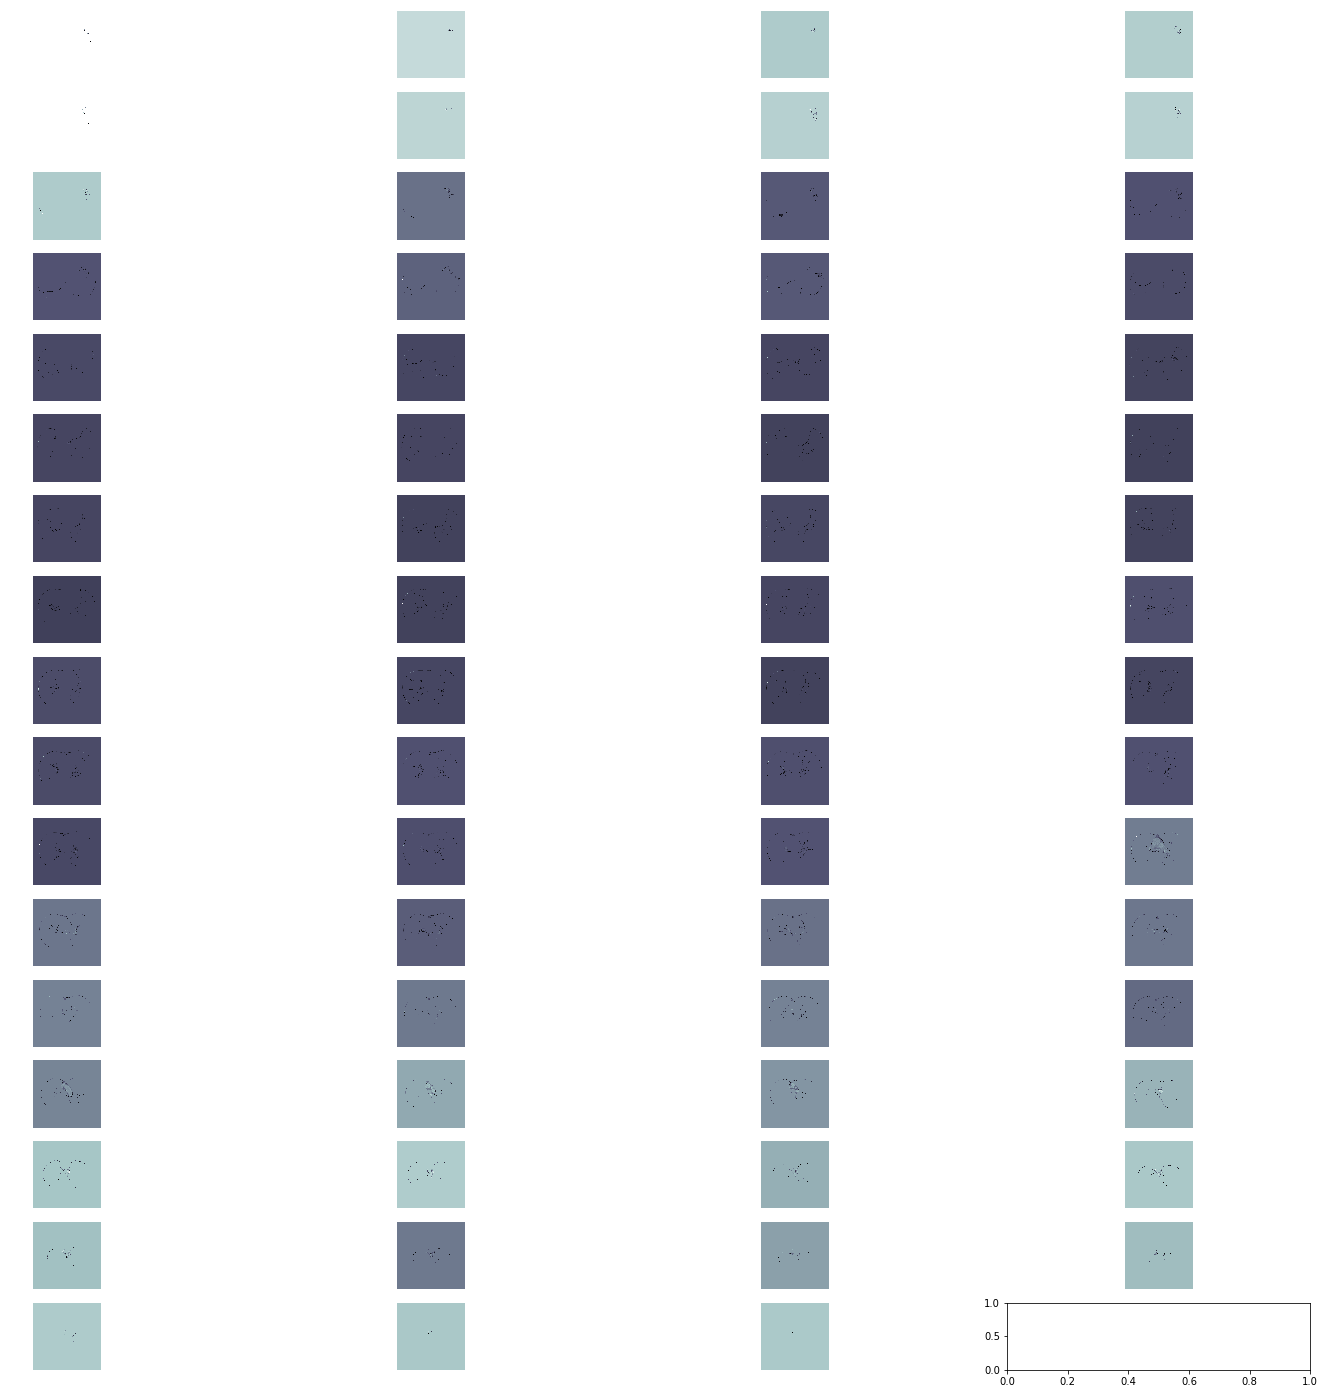

In [44]:
#plot_3d(image)%%time
plot_ct_scan(segmented_ct_scan)

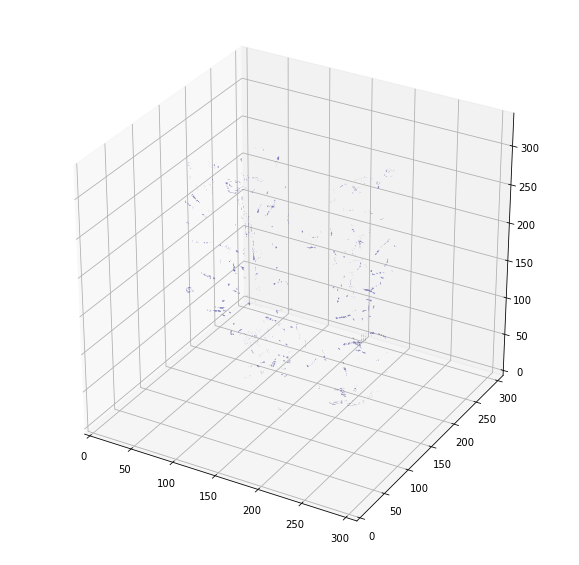

In [45]:
plot_3d(segmented_nodules)

__Maintenant que les nodules sont isolés, on va essayer de les détecter et balancer des patch autour__

In [17]:
len(areas)

2335

In [18]:
np.set_printoptions(threshold = np.nan)

segmented_nodules_pad = np.copy(segmented_nodules)
#Padding des segmented_nodules pour eviter les pb si un nodules est sur un coin (cf ce qu'on fait ci dessous)
segmented_nodules_pad = np.pad(segmented_nodules,((8,8),(8,8),(8,8)),'constant',constant_values=0)

sleme = ball(2)
binary = binary_closing(segmented_nodules_pad, selem)
label_scan = label(binary)

areas = [r.area for r in regionprops(label_scan)]
center_full = [r.centroid  for r in regionprops(label_scan)]

nodules = []
for r in center_full:
    nodules.append(segmented_nodules_pad[int(r[0])-8:int(r[0])+8,int(r[1])-8:int(r[1])+8,int(r[2])-8:int(r[2])+8])

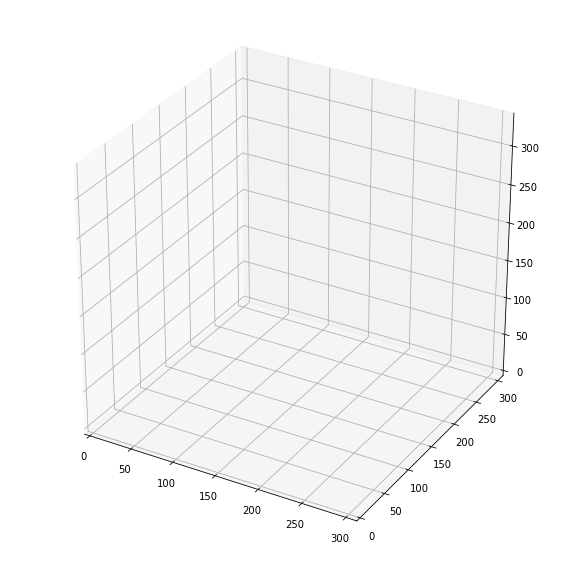

In [22]:
plot_3d(segmented_nodules, -400) 